In [3]:
import pandas as pd
import numpy as np
print("Pandas version:", pd.__version__)

Pandas version: 3.0.1


In [14]:
df = pd.read_parquet('data/raw/train_part_1.parquet', engine='fastparquet')
print("Размер:", df.shape)
print("Все колонки в данных:")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

Размер: (28618594, 23)
Все колонки в данных:
0: customer_id
1: event_id
2: event_dttm
3: event_type_nm
4: event_desc
5: channel_indicator_type
6: channel_indicator_sub_type
7: operaton_amt
8: currency_iso_cd
9: mcc_code
10: pos_cd
11: accept_language
12: browser_language
13: timezone
14: session_id
15: operating_system_type
16: battery
17: device_system_version
18: screen_size
19: developer_tools
20: phone_voip_call_state
21: web_rdp_connection
22: compromised


In [16]:
labels = pd.read_parquet('data/raw/train_labels.parquet', engine='fastparquet')
print("Размер лейблов:", labels.shape)
print("Колонки:", labels.columns.tolist())
print("\nПервые строки:")
labels.head()

Размер лейблов: (87514, 3)
Колонки: ['customer_id', 'event_id', 'target']

Первые строки:


,customer_id,event_id,target
0,123123123123129,124093788813382,0
1,123123123123138,126035112904381,0
2,123123123123169,124325714018852,1
3,123123123123169,124944191029616,1
4,123123123123169,126395888234936,1


In [4]:
# Обьединение всех частей в одну + накинули метки
import glob
import os


os.makedirs('data/processed', exist_ok=True)


labels = pd.read_parquet('data/raw/train_labels.parquet')
print(f"Лейблов: {len(labels):,}")


train_files = sorted(glob.glob('data/raw/train_part*.parquet'))
print(f"Найдено файлов: {len(train_files)}")


for i, file in enumerate(train_files):
    print(f"\n[{i+1}/{len(train_files)}] Загружаем {file}...")
    
    
    df_part = pd.read_parquet(file, engine='fastparquet')
    print(f"  Строк в части: {len(df_part):,}")
    
    
    df_part = df_part.merge(labels[['event_id', 'target']], on='event_id', how='left')
    
    
    target_counts = df_part['target'].value_counts(dropna=False)
    print(f"  target=1: {target_counts.get(1, 0)}")
    print(f"  target=0: {target_counts.get(0, 0)}")
    print(f"  target=NaN: {target_counts.get(np.nan, 0)}")
    
    output_file = f'data/processed/train_part_{i+1}_with_labels.parquet'
    df_part.to_parquet(output_file, index=False)
    print(f"  Сохранено в {output_file}")
    
    del df_part

print("\n✅ Все train части обработаны")

Лейблов: 87,514
Найдено файлов: 3

[1/3] Загружаем data/raw/train_part_1.parquet...
  Строк в части: 28,618,594
  target=1: 17384
  target=0: 12082
  target=NaN: 28589128
  Сохранено в data/processed/train_part_1_with_labels.parquet

[2/3] Загружаем data/raw/train_part_2.parquet...
  Строк в части: 28,558,397
  target=1: 17157
  target=0: 12021
  target=NaN: 28529219
  Сохранено в data/processed/train_part_2_with_labels.parquet

[3/3] Загружаем data/raw/train_part_3.parquet...
  Строк в части: 28,500,849
  target=1: 16897
  target=0: 11973
  target=NaN: 28471979
  Сохранено в data/processed/train_part_3_with_labels.parquet

✅ Все train части обработаны


In [10]:
# Смотрим pretrain
pretrain_files = sorted(glob.glob('data/raw/pretrain_part*.parquet'))

total_rows = 0
for file in pretrain_files:
    df = pd.read_parquet(file, engine='fastparquet', columns=['event_id'])
    rows = len(df)
    print(f"{file}: {rows:,} строк")
    total_rows += rows
    del df

print(f"\nВсего в pretrain: {total_rows:,} строк")

data/raw/pretrain_part_1.parquet: 30,329,960 строк
data/raw/pretrain_part_2.parquet: 30,237,860 строк
data/raw/pretrain_part_3.parquet: 30,372,137 строк

Всего в pretrain: 90,939,957 строк


In [11]:
# EDA

import glob
from collections import Counter

train_files = sorted(glob.glob('data/processed/train_part_*_with_labels.parquet'))
print(f"Анализируем {len(train_files)} файлов...\n")


total_rows = 0
total_cols = 0
dtypes_counter = Counter()
missing_stats = {}
target_counts_total = {'target=1': 0, 'target=0': 0, 'target=NaN': 0}


for i, file in enumerate(train_files):
    print(f"[{i+1}/{len(train_files)}] Анализируем {file}...")
    

    df = pd.read_parquet(file, engine='fastparquet')
    rows, cols = df.shape
    total_rows += rows
    total_cols = cols
    

    dtypes_counter.update(df.dtypes.astype(str).value_counts().to_dict())
    

    missing = (df.isnull().sum() / rows * 100).to_dict()
    for col, pct in missing.items():
        if pct > 0:
            if col not in missing_stats:
                missing_stats[col] = []
            missing_stats[col].append(pct)
    

    target_counts = df['target'].value_counts(dropna=False)
    target_counts_total['target=1'] += target_counts.get(1, 0)
    target_counts_total['target=0'] += target_counts.get(0, 0)
    target_counts_total['target=NaN'] += target_counts.get(np.nan, 0)
    

    del df

print("\n" + "="*50)
print("ИТОГОВЫЙ АНАЛИЗ ВСЕХ TRAIN ЧАСТЕЙ")
print("="*50)

print(f"\n📊 РАЗМЕР ДАННЫХ:")
print(f"  Всего строк: {total_rows:,}")
print(f"  Всего колонок: {total_cols}")

print(f"\n📊 ТИПЫ ДАННЫХ:")
for dtype, count in dtypes_counter.most_common():
    print(f"  {dtype}: {count} колонок")

print(f"\n📊 ПРОПУСКИ (средний % по всем частям):")
missing_avg = {col: np.mean(pcts) for col, pcts in missing_stats.items()}
for col, pct in sorted(missing_avg.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {col}: {pct:.2f}%")

print(f"\n📊 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ (target):")
total_labeled = target_counts_total['target=1'] + target_counts_total['target=0']
print(f"  Всего операций с обратной связью: {total_labeled:,}")
print(f"  🔴 target=1 (мошенничество): {target_counts_total['target=1']:,} ({target_counts_total['target=1']/total_rows*100:.4f}%)")
print(f"  🟡 target=0 (подтверждено): {target_counts_total['target=0']:,} ({target_counts_total['target=0']/total_rows*100:.4f}%)")
print(f"  🟢 target=NaN (без обратной связи): {target_counts_total['target=NaN']:,} ({target_counts_total['target=NaN']/total_rows*100:.2f}%)")

Анализируем 3 файлов...

[1/3] Анализируем data/processed/train_part_1_with_labels.parquet...
[2/3] Анализируем data/processed/train_part_2_with_labels.parquet...
[3/3] Анализируем data/processed/train_part_3_with_labels.parquet...

ИТОГОВЫЙ АНАЛИЗ ВСЕХ TRAIN ЧАСТЕЙ

📊 РАЗМЕР ДАННЫХ:
  Всего строк: 85,677,840
  Всего колонок: 24

📊 ТИПЫ ДАННЫХ:
  object: 27 колонок
  float64: 27 колонок
  int32: 12 колонок
  int64: 6 колонок

📊 ПРОПУСКИ (средний % по всем частям):
  target: 99.90%
  pos_cd: 91.30%
  browser_language: 90.82%
  battery: 90.82%
  operating_system_type: 90.65%
  timezone: 90.47%
  accept_language: 88.95%
  web_rdp_connection: 84.19%
  phone_voip_call_state: 79.15%
  mcc_code: 71.26%

📊 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ (target):
  Всего операций с обратной связью: 87,514
  🔴 target=1 (мошенничество): 51,438 (0.0600%)
  🟡 target=0 (подтверждено): 36,076 (0.0421%)
  🟢 target=NaN (без обратной связи): 85,590,326 (99.90%)


Статистика operaton_amt по классам:
                               count          mean           std  min  \
target_class                                                            
🔴 fraud                      10139.0  7.042597e+06  2.650334e+07  0.0   
🟡 suspicious (confirmed)      6603.0  2.288594e+07  1.748245e+08  0.0   
🟢 normal                  15248485.0  2.439306e+06  2.127305e+08  0.0   

                              25%        50%         75%           max  
target_class                                                            
🔴 fraud                   39766.0   362916.0   4993050.0  1.150380e+09  
🟡 suspicious (confirmed)  75004.0  1010000.0  16015352.0  1.276288e+10  
🟢 normal                  24005.0    71137.0    277187.0  2.768517e+11  


/var/folders/m_/_6k6hqs94h9bmkxzqhy56x0r0000gn/T/ipykernel_56842/3238013369.py:34: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/m_/_6k6hqs94h9bmkxzqhy56x0r0000gn/T/ipykernel_56842/3238013369.py:34: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/m_/_6k6hqs94h9bmkxzqhy56x0r0000gn/T/ipykernel_56842/3238013369.py:34: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/vladimirolejnik/Projects/DFC2026/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/vladimirolejnik/Projects/DFC2026/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.can

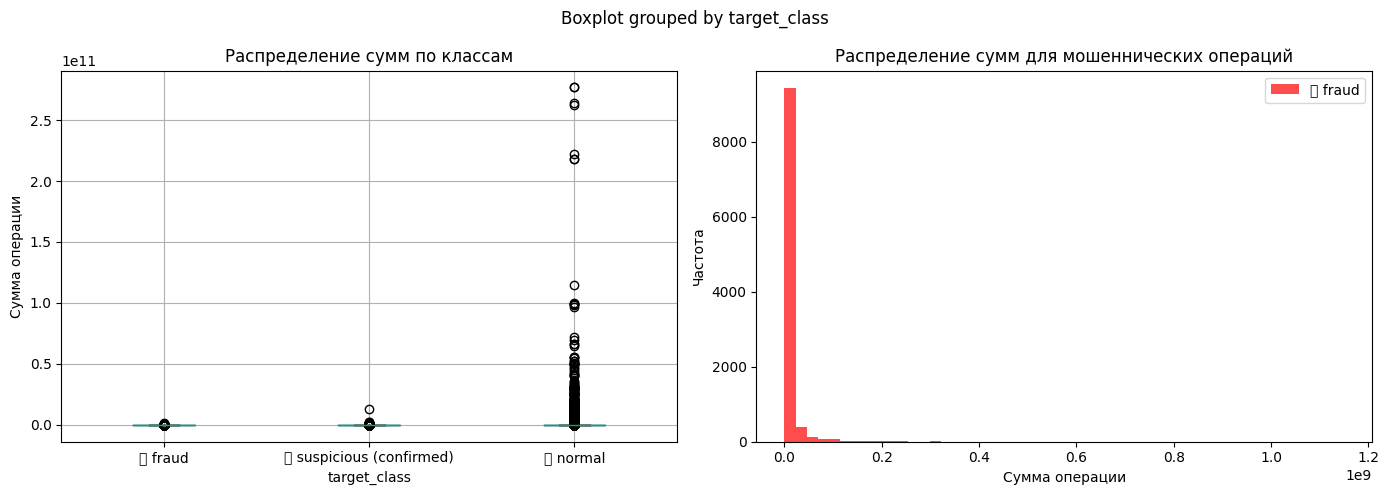

In [12]:
# Анализ суммы операций


df_sample = pd.read_parquet('data/processed/train_part_1_with_labels.parquet', engine='fastparquet')


df_sample['target_class'] = '🟢 normal'
df_sample.loc[df_sample['target'] == 0, 'target_class'] = '🟡 suspicious (confirmed)'
df_sample.loc[df_sample['target'] == 1, 'target_class'] = '🔴 fraud'


print("Статистика operaton_amt по классам:")
print(df_sample.groupby('target_class')['operaton_amt'].describe())


import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


df_sample.boxplot(column='operaton_amt', by='target_class', ax=axes[0])
axes[0].set_title('Распределение сумм по классам')
axes[0].set_ylabel('Сумма операции')


fraud_amt = df_sample[df_sample['target'] == 1]['operaton_amt'].dropna()
if len(fraud_amt) > 0:
    axes[1].hist(fraud_amt, bins=50, alpha=0.7, color='red', label='🔴 fraud')
    axes[1].set_title('Распределение сумм для мошеннических операций')
    axes[1].set_xlabel('Сумма операции')
    axes[1].set_ylabel('Частота')
    axes[1].legend()

plt.tight_layout()
plt.show()

del df_sample

In [13]:
df_sample = pd.read_parquet('data/processed/train_part_1_with_labels.parquet', engine='fastparquet')

# Смотрим квантили для нормальных операций
print("Квантили для нормальных операций (🟢):")
normal_amt = df_sample[df_sample['target'].isna()]['operaton_amt'].dropna()
for q in [0.5, 0.75, 0.9, 0.95, 0.99, 0.999]:
    print(f"{q*100:.1f}%: {normal_amt.quantile(q):,.0f}")

# Смотрим, сколько мошеннических операций попадает в разные диапазоны
print("\nМошеннические операции (🔴) по диапазонам:")
fraud_amt = df_sample[df_sample['target'] == 1]['operaton_amt'].dropna()
print(f"  Всего мошеннических: {len(fraud_amt)}")
print(f"  До 100k: {(fraud_amt <= 100000).sum()} ({(fraud_amt <= 100000).sum()/len(fraud_amt)*100:.1f}%)")
print(f"  100k-1M: {((fraud_amt > 100000) & (fraud_amt <= 1000000)).sum()} ({((fraud_amt > 100000) & (fraud_amt <= 1000000)).sum()/len(fraud_amt)*100:.1f}%)")
print(f"  1M-10M: {((fraud_amt > 1000000) & (fraud_amt <= 10000000)).sum()} ({((fraud_amt > 1000000) & (fraud_amt <= 10000000)).sum()/len(fraud_amt)*100:.1f}%)")
print(f"  >10M: {(fraud_amt > 10000000).sum()} ({(fraud_amt > 10000000).sum()/len(fraud_amt)*100:.1f}%)")

del df_sample

Квантили для нормальных операций (🟢):
50.0%: 71,137
75.0%: 277,187
90.0%: 1,236,138
95.0%: 3,655,314
99.0%: 29,943,000
99.9%: 200,360,000

Мошеннические операции (🔴) по диапазонам:
  Всего мошеннических: 10139
  До 100k: 3950 (39.0%)
  100k-1M: 2031 (20.0%)
  1M-10M: 2684 (26.5%)
  >10M: 1474 (14.5%)


In [14]:
# Анализ пропусков в колонках

df_sample = pd.read_parquet('data/processed/train_part_1_with_labels.parquet', engine='fastparquet')


important_cols = ['mcc_code', 'pos_cd', 'channel_indicator_type', 
                  'channel_indicator_sub_type', 'event_type_nm', 'event_desc']

print("Пропуски в важных колонках (%):")
for col in important_cols:
    if col in df_sample.columns:
        missing_pct = df_sample[col].isnull().mean() * 100
        print(f"  {col}: {missing_pct:.2f}%")


print("\nПропуски для мошеннических операций (🔴):")
fraud_mask = df_sample['target'] == 1
for col in important_cols:
    if col in df_sample.columns:
        missing_pct = df_sample[fraud_mask][col].isnull().mean() * 100
        print(f"  {col}: {missing_pct:.2f}%")

del df_sample

Пропуски в важных колонках (%):
  mcc_code: 71.42%
  pos_cd: 91.32%
  channel_indicator_type: 0.00%
  channel_indicator_sub_type: 0.00%
  event_type_nm: 0.00%
  event_desc: 0.00%

Пропуски для мошеннических операций (🔴):
  mcc_code: 69.37%
  pos_cd: 80.76%
  channel_indicator_type: 0.00%
  channel_indicator_sub_type: 0.00%
  event_type_nm: 0.00%
  event_desc: 0.00%


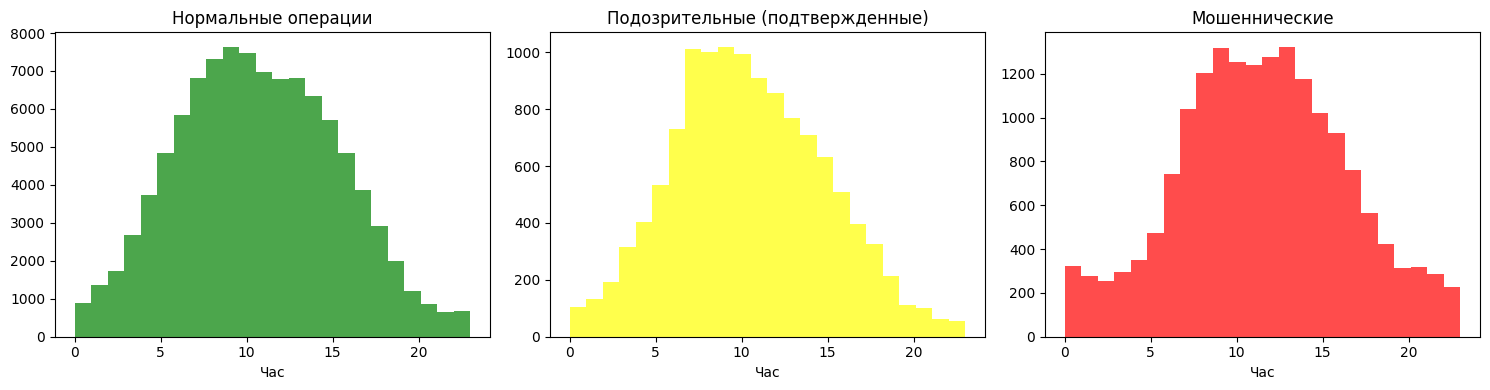

Доля операций в выходные:
  🟢 normal: 24.27%
  🟡 suspicious: 18.90%
  🔴 fraud: 21.58%


In [15]:
# Анализ времени операций

df_sample = pd.read_parquet('data/processed/train_part_1_with_labels.parquet', engine='fastparquet')


df_sample['event_dttm'] = pd.to_datetime(df_sample['event_dttm'])
df_sample['hour'] = df_sample['event_dttm'].dt.hour
df_sample['day_of_week'] = df_sample['event_dttm'].dt.dayofweek  # 0=пн, 6=вс
df_sample['is_weekend'] = df_sample['day_of_week'].isin([5, 6]).astype(int)


fig, axes = plt.subplots(1, 3, figsize=(15, 4))


normal_mask = df_sample['target'].isna()
normal_sample = df_sample[normal_mask].sample(min(100000, normal_mask.sum()), random_state=42)
axes[0].hist(normal_sample['hour'], bins=24, alpha=0.7, color='green', label='🟢 normal')
axes[0].set_title('Нормальные операции')
axes[0].set_xlabel('Час')


susp_mask = df_sample['target'] == 0
if susp_mask.sum() > 0:
    axes[1].hist(df_sample[susp_mask]['hour'], bins=24, alpha=0.7, color='yellow', label='🟡 suspicious')
axes[1].set_title('Подозрительные (подтвержденные)')
axes[1].set_xlabel('Час')


fraud_mask = df_sample['target'] == 1
if fraud_mask.sum() > 0:
    axes[2].hist(df_sample[fraud_mask]['hour'], bins=24, alpha=0.7, color='red', label='🔴 fraud')
axes[2].set_title('Мошеннические')
axes[2].set_xlabel('Час')

plt.tight_layout()
plt.show()

# Смотрим выходные
print("Доля операций в выходные:")
print(f"  🟢 normal: {normal_sample['is_weekend'].mean()*100:.2f}%")
print(f"  🟡 suspicious: {df_sample[susp_mask]['is_weekend'].mean()*100:.2f}%" if susp_mask.sum() > 0 else "  🟡 suspicious: нет данных")
print(f"  🔴 fraud: {df_sample[fraud_mask]['is_weekend'].mean()*100:.2f}%" if fraud_mask.sum() > 0 else "  🔴 fraud: нет данных")

del df_sample